# Import des modules

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Chargement et normalisation des données

In [2]:
df_in = pd.read_csv("bdd_in_mat_05.csv", sep=None, engine="python")  # auto-détection
df_out = pd.read_csv("bdd_out_mat_05.csv", sep=None, engine="python")  # auto-détection

# conversion en numpy
u_np = df_in.to_numpy(dtype=float)
y_np = df_out.to_numpy(dtype=float)

print(u_np.shape, y_np.shape)  # (3000, 2000) attendu

(2999, 2000) (2999, 2000)


In [3]:
# Normalisation type "z-score" ou min-max
u_mean, u_std = u_np.mean(), u_np.std() + 1e-9
y_mean, y_std = y_np.mean(), y_np.std() + 1e-9

u_norm = (u_np - u_mean) / u_std
y_norm = (y_np - y_mean) / y_std


In [4]:
N_seq, T = u_norm.shape

# On ajoute une dernière dimension pour "input_size=1" / "output_size=1"
u_seq = u_norm[:, :, None]  # (N_seq, T, 1)
y_seq = y_norm[:, :, None]  # (N_seq, T, 1)

# Split train / val / test
idx = np.random.permutation(N_seq)

ratio_train = 0.7
ratio_val   = 0.15

n_train = int(ratio_train * N_seq)
n_val   = int(ratio_val   * N_seq)

idx_train = idx[:n_train]
idx_val   = idx[n_train:n_train+n_val]
idx_test  = idx[n_train+n_val:]

u_train, y_train = u_seq[idx_train], y_seq[idx_train]
u_val,   y_val   = u_seq[idx_val],   y_seq[idx_val]
u_test,  y_test  = u_seq[idx_test],  y_seq[idx_test]


## Création du Dataset PyTorch

In [5]:
class SequenceDataset(Dataset):
    def __init__(self, u, y):
        """
        u : (N_seq, T, 1)
        y : (N_seq, T, 1)
        """
        self.u = torch.from_numpy(u).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return self.u.shape[0]

    def __getitem__(self, idx):
        return self.u[idx], self.y[idx]

train_ds = SequenceDataset(u_train, y_train)
val_ds   = SequenceDataset(u_val,   y_val)
test_ds  = SequenceDataset(u_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False)


# Entraînement du modèle

In [6]:
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=20, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            nonlinearity="tanh",
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, u, h0=None):
        """
        u : (batch, T, 1)
        h0: (1, batch, hidden_size) ou None
        """
        # h : (batch, T, hidden_size)
        h, h_last = self.rnn(u, h0)
        # y_pred : (batch, T, 1)
        y_pred = self.fc(h)
        return y_pred, h

In [7]:
# Instanciation du modèle, de la loss et de l'optimizer
#Paramètres
input_size = 1
hidden_size = 10
output_size = 1

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = RNNModel(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [8]:
# Entrainement du modèle
n_epochs = 20

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0

    for u_batch, y_batch in train_loader:
        u_batch = u_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred, _ = model(u_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * u_batch.size(0)

    train_loss /= len(train_ds)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for u_batch, y_batch in val_loader:
            u_batch = u_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred, _ = model(u_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * u_batch.size(0)
    val_loss /= len(val_ds)

    print(f"Epoch {epoch+1}/{n_epochs} - train_loss={train_loss:.4e} - val_loss={val_loss:.4e}")


Epoch 1/20 - train_loss=9.3557e-01 - val_loss=1.0453e+00
Epoch 2/20 - train_loss=7.2072e-01 - val_loss=8.4393e-01
Epoch 3/20 - train_loss=4.7084e-01 - val_loss=5.1335e-01
Epoch 4/20 - train_loss=1.5680e-01 - val_loss=3.5010e-01
Epoch 5/20 - train_loss=1.0721e-01 - val_loss=3.3488e-01
Epoch 6/20 - train_loss=9.6121e-02 - val_loss=3.2506e-01
Epoch 7/20 - train_loss=8.6410e-02 - val_loss=3.1490e-01
Epoch 8/20 - train_loss=7.6529e-02 - val_loss=3.0465e-01
Epoch 9/20 - train_loss=6.6938e-02 - val_loss=2.9693e-01
Epoch 10/20 - train_loss=6.1062e-02 - val_loss=2.9431e-01
Epoch 11/20 - train_loss=5.9514e-02 - val_loss=2.9145e-01
Epoch 12/20 - train_loss=5.8557e-02 - val_loss=2.9090e-01
Epoch 13/20 - train_loss=5.6770e-02 - val_loss=2.9052e-01
Epoch 14/20 - train_loss=5.6762e-02 - val_loss=2.8865e-01
Epoch 15/20 - train_loss=5.5355e-02 - val_loss=2.8805e-01
Epoch 16/20 - train_loss=5.4895e-02 - val_loss=2.8843e-01
Epoch 17/20 - train_loss=5.4978e-02 - val_loss=2.8756e-01
Epoch 18/20 - train_los

# Extraction des paramètres du modèle

In [9]:
# Extraction des poids et biais
def extract_rnn_parameters(model, u_mean, u_std, y_mean, y_std):
    """
    Retourne un dict contenant :
      - Wu, Wx, bxu : dynamiques cachées (tanh)
      - C, b_y      : sortie linéaire
      - u_mean, u_std, y_mean, y_std : normalisation
      - b_ih, b_hh  : biais séparés (au cas où)
    """
    model.eval()
    with torch.no_grad():
        # --- RNN interne ---
        Wu_torch = model.rnn.weight_ih_l0      # (hidden_size, input_size)
        Wx_torch = model.rnn.weight_hh_l0      # (hidden_size, hidden_size)
        b_ih_t   = model.rnn.bias_ih_l0        # (hidden_size,)
        b_hh_t   = model.rnn.bias_hh_l0        # (hidden_size,)

        # --- Couche de sortie ---
        C_torch   = model.fc.weight            # (output_size, hidden_size)
        b_y_torch = model.fc.bias              # (output_size,)

        # Passage en NumPy sur CPU
        Wu  = Wu_torch.detach().cpu().numpy()      # (H, 1)
        Wx  = Wx_torch.detach().cpu().numpy()      # (H, H)
        b_ih = b_ih_t.detach().cpu().numpy()       # (H,)
        b_hh = b_hh_t.detach().cpu().numpy()       # (H,)
        bxu  = b_ih + b_hh                         # (H,)

        C   = C_torch.detach().cpu().numpy()       # (1, H)
        b_y = b_y_torch.detach().cpu().numpy()     # (1,)

    params = {
        "Wu": Wu,          # (H, 1)
        "Wx": Wx,          # (H, H)
        "bxu": bxu,        # (H,)
        "b_ih": b_ih,
        "b_hh": b_hh,
        "C": C,            # (1, H)
        "b_y": b_y,        # (1,)

        # Normalisation (très important pour reproduire le modèle)
        "u_mean": float(u_mean),
        "u_std":  float(u_std),
        "y_mean": float(y_mean),
        "y_std":  float(y_std),
    }

    return params


In [10]:
params = extract_rnn_parameters(model, u_mean, u_std, y_mean, y_std)

for k, v in params.items():
    if isinstance(v, np.ndarray):
        print(k, v.shape)
    else:
        print(k, v)

Wu (10, 1)
Wx (10, 10)
bxu (10,)
b_ih (10,)
b_hh (10,)
C (1, 10)
b_y (1,)
u_mean -0.0018277701156940382
u_std 0.5726249834375675
y_mean -9.785419181281858
y_std 12.394674533355728


# Vérification des modèles obtenus

In [11]:
def rnn_step_from_params(x, u_raw, params):
    """
    Un pas de temps du RNN reconstruit à partir des matrices.
    x     : état actuel (H,)
    u_raw : commande brute (non normalisée)
    """
    Wu   = params["Wu"]    # (H, 1)
    Wx   = params["Wx"]    # (H, H)
    bxu  = params["bxu"]   # (H,)
    C    = params["C"]     # (1, H)
    b_y  = params["b_y"]   # (1,)
    u_m  = params["u_mean"]
    u_s  = params["u_std"]
    y_m  = params["y_mean"]
    y_s  = params["y_std"]

    # Normalisation de la commande
    u_norm = (u_raw - u_m) / (u_s + 1e-9)
    u_vec = np.array([u_norm])  # (1,)

    # Dynamique cachée
    x_next = np.tanh(Wx @ x + Wu @ u_vec + bxu)  # (H,)

    # Sortie normalisée puis dénormalisée
    y_norm = C @ x_next + b_y                    # (1,)
    y = y_norm * y_s + y_m                       # scalaire

    return x_next, float(y)


def simulate_rnn_from_params(u_seq_raw, params, x0=None):
    """
    Simule toute une séquence avec le RNN reconstruit.
    u_seq_raw : (T,) commandes brutes
    """
    H = params["Wx"].shape[0]
    T = len(u_seq_raw)

    if x0 is None:
        x = np.zeros(H)
    else:
        x = np.array(x0, dtype=float).reshape(H,)

    y_seq = np.zeros(T)
    x_seq = np.zeros((T+1, H))
    x_seq[0] = x

    for k in range(T):
        x, y = rnn_step_from_params(x, u_seq_raw[k], params)
        x_seq[k+1] = x
        y_seq[k] = y

    return y_seq, x_seq


In [12]:
import matplotlib.pyplot as plt

def compare_rnn_implementations(model,
                                params,
                                u_np, y_np,
                                idx_test,
                                i_seq=0,
                                device=torch.device("cpu")):
    """
    Compare pour UNE séquence de test :
      - sortie réelle (y_true)
      - sortie PyTorch (y_pred_pt)
      - sortie RNN reconstruit (y_pred_reimpl)

    u_np, y_np : données brutes (non normalisées), shape (N_seq, T)
    idx_test   : indices des séquences de test (array/list)
    i_seq      : index dans idx_test de la séquence à tracer
    """
    model.eval()

    # ---- 1) Récupère la séquence brute de test ----
    seq_id = idx_test[i_seq]
    u_seq_raw = u_np[seq_id]   # (T,)
    y_true_raw = y_np[seq_id]  # (T,)

    u_m = params["u_mean"]
    u_s = params["u_std"]
    y_m = params["y_mean"]
    y_s = params["y_std"]

    # ---- 2) Prédiction PyTorch (modèle original) ----
    # Normalisation identique à l'entraînement
    u_seq_norm = (u_seq_raw - u_m) / (u_s + 1e-9)
    u_torch = torch.from_numpy(u_seq_norm.astype(np.float32)).view(1, -1, 1).to(device)

    with torch.no_grad():
        y_pred_norm_torch, _ = model(u_torch)      # (1, T, 1)
        y_pred_norm_np = y_pred_norm_torch.cpu().numpy().reshape(-1)  # (T,)

    # Dénormalisation sortie
    y_pred_pt = y_pred_norm_np * y_s + y_m        # (T,)

    # ---- 3) Prédiction RNN reconstruit ----
    y_pred_reimpl, _ = simulate_rnn_from_params(u_seq_raw, params)

    # ---- 4) Comparaisons chiffrées ----
    def rmse(a, b):
        return float(np.sqrt(np.mean((a - b)**2)))

    def mae(a, b):
        return float(np.mean(np.abs(a - b)))

    rmse_true_pt     = rmse(y_true_raw,   y_pred_pt)
    rmse_true_reimpl = rmse(y_true_raw,   y_pred_reimpl)
    rmse_pt_reimpl   = rmse(y_pred_pt,    y_pred_reimpl)

    mae_true_pt      = mae(y_true_raw,    y_pred_pt)
    mae_true_reimpl  = mae(y_true_raw,    y_pred_reimpl)
    mae_pt_reimpl    = mae(y_pred_pt,     y_pred_reimpl)

    print("\n=== Comparaison pour la séquence test idx =", seq_id, "=== ")
    print(f"RMSE(y_true, y_pt)      = {rmse_true_pt:.6e}")
    print(f"RMSE(y_true, y_reimpl)  = {rmse_true_reimpl:.6e}")
    print(f"RMSE(y_pt,   y_reimpl)  = {rmse_pt_reimpl:.6e}")
    print(f"MAE (y_true, y_pt)      = {mae_true_pt:.6e}")
    print(f"MAE (y_true, y_reimpl)  = {mae_true_reimpl:.6e}")
    print(f"MAE (y_pt,   y_reimpl)  = {mae_pt_reimpl:.6e}")

    # ---- 5) Tracé ----
    T = len(u_seq_raw)
    t = np.arange(T)

    plt.figure(figsize=(10, 4))
    plt.plot(t, y_true_raw,      label="Sortie réelle (y_true)", linewidth=2)
    plt.plot(t, y_pred_pt,       label="PyTorch (y_pred_pt)",    linestyle="--")
    plt.plot(t, y_pred_reimpl,   label="RNN matrices (y_reimpl)", linestyle=":")
    plt.xlabel("Time step k")
    plt.ylabel("Accélération az")
    plt.title(f"Comparaison des sorties - séquence test {seq_id}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



=== Comparaison pour la séquence test idx = 363 === 
RMSE(y_true, y_pt)      = 8.110236e-01
RMSE(y_true, y_reimpl)  = 8.110235e-01
RMSE(y_pt,   y_reimpl)  = 1.344405e-06
MAE (y_true, y_pt)      = 5.084492e-01
MAE (y_true, y_reimpl)  = 5.084492e-01
MAE (y_pt,   y_reimpl)  = 1.095184e-06


/var/folders/r8/y4thjhf922d78bymkxlp4b_40000gn/T/ipykernel_87416/3298431671.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return x_next, float(y)


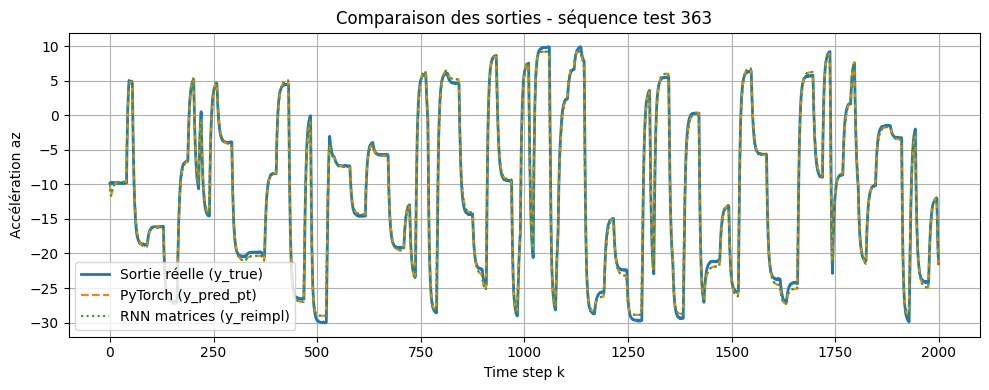

In [13]:
# 1) Extraire les paramètres (déjà vu)
params = extract_rnn_parameters(model, u_mean, u_std, y_mean, y_std)

# 2) Suppose que tu as encore sous la main u_np, y_np et idx_test
#    (les données brutes AVANT normalisation)
compare_rnn_implementations(
    model=model,
    params=params,
    u_np=u_np,
    y_np=y_np,
    idx_test=idx_test,
    i_seq=0,          # séquence de test à visualiser
    device=device
)

# Exportation des paramètres du modèle en .json, .npz, .mat

In [14]:
import json
from scipy.io import savemat

def export_rnn_parameters(params, basename="rnn_model_params"):
    """
    Exporte les paramètres d'un RNN dans deux formats :
      - JSON (lisible universellement)
      - MAT  (compatible MATLAB)
    
    Arguments
    ---------
    params : dict
        Dictionnaire renvoyé par extract_rnn_parameters()
    basename : str
        Nom de base des fichiers exportés (sans extension)
    """

    # ---------- Export JSON ----------
    json_dict = {}
    for k, v in params.items():
        if isinstance(v, np.ndarray):
            json_dict[k] = v.tolist()              # conversion vers listes JSON
        elif np.isscalar(v):
            json_dict[k] = float(v)
        else:
            try:
                json_dict[k] = np.array(v).tolist()
            except Exception:
                json_dict[k] = str(v)

    with open(basename + ".json", "w") as f:
        json.dump(json_dict, f, indent=4)
    print(f"Fichier {basename}.json exporté (format universel lisible).")

    # ---------- Export MATLAB ----------
    matdict = {k: np.array(v, dtype=np.float64) for k, v in params.items()}
    savemat(basename + ".mat", matdict)
    print(f"Fichier {basename}.mat exporté (compatible MATLAB).")

    print("Export terminé avec succès !")

In [15]:
params = extract_rnn_parameters(model, u_mean, u_std, y_mean, y_std)
export_rnn_parameters(params, basename="rnn_quadrotor_model")

Fichier rnn_quadrotor_model.json exporté (format universel lisible).
Fichier rnn_quadrotor_model.mat exporté (compatible MATLAB).
Export terminé avec succès !
